In [1]:
import os
import pandas as pd
import numpy as np
import torch
import re
from transformers import AutoTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [2]:
# 读取csv文件
df = pd.read_csv("./Sentiment_Analysis.csv")
print(df.head())

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [3]:
# 样本数
print(df.shape)

(53043, 3)


In [4]:
# 不同标签的个数
print(df["status"].value_counts())

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


In [5]:
# 缺失值的个数
print(df.isnull().sum())

Unnamed: 0      0
statement     362
status          0
dtype: int64


In [6]:
"""
pandas中的Series简析：
    它是一个一维数组，不过每个元素都可以带一个索引。
    DataFrame的value_counts会返回Series对象
"""
print(df["status"].value_counts(),'\n')
print(df["status"].value_counts().index,'\n')
print(df["status"].value_counts().values,'\n')

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64 

Index(['Normal', 'Depression', 'Suicidal', 'Anxiety', 'Bipolar', 'Stress',
       'Personality disorder'],
      dtype='object', name='status') 

[16351 15404 10653  3888  2877  2669  1201] 



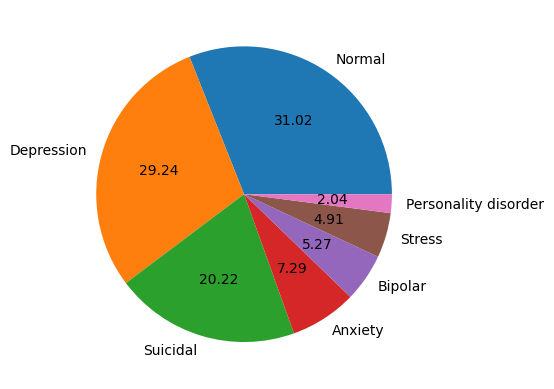

In [7]:
# 处理包含缺失值的行，删除开始的索引列
df.drop("Unnamed: 0",axis=1,inplace=True)
df.dropna(axis=0, inplace=True)

# 可视化数据集
import matplotlib.pyplot as plt
# pie函数用于绘制饼图，第一个参数传各个属性所占的比例，labels可以传属性的标签，autopct是数据的格式
plt.pie(df["status"].value_counts().to_list(), labels = df["status"].value_counts().index.to_list(), autopct="%.2f")
plt.show()

In [8]:
le = LabelEncoder() # sklearn.preprocessing
df["status"] = le.fit_transform(df["status"]) # LabelEncoder可以完成标签的编码，fit_transform是编码并转换标签的函数
print(df["status"].value_counts())

status
3    16343
2    15404
6    10652
0     3841
1     2777
5     2587
4     1077
Name: count, dtype: int64


In [9]:
# 计算每个类别的权重
# 对于标签的不同类别，占总样本的比例越小，其权重就会越大
class_weights = compute_class_weight( # sklearn.utils.class_weight
    class_weight="balanced",
    classes=np.unique(df["status"]),
    y=df["status"]
)
print(class_weights)

[1.95934838 2.71006739 0.48856512 0.46049423 6.98779679 2.90910597
 0.70652057]


In [10]:
# 使用正则匹配网址等信息，并剔除
def preprocess(text):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["statement"] = df["statement"].apply(preprocess)
# stratify参数的作用为：按照传入参数的比例分层抽样，保证测试集和训练集中不同类别所占的比例相同，通常传入和标签一致
X_train, X_test, y_train, y_test = train_test_split(df["statement"], df["status"], test_size = 0.2, stratify=df["status"], random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42144,)
(10537,)
(42144,)
(10537,)


In [11]:
class SentimentDataset(Dataset):
    def __init__(self, labels, tokens):
        super().__init__()
        self.labels = labels
        self.tokens = tokens
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            "input_ids": self.tokens["input_ids"][idx],
            "attention_mask": self.tokens["attention_mask"][idx],
            "label": torch.tensor(self.labels[idx], dtype = torch.long)
        }

In [12]:
"""
bert-base-uncased:
    transfromer提供的用于预处理英文数据的模型
    uncased  --  分词前将所有单词转为小写，忽略大小写差异
"""
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

training_tokens = tokenizer(
    X_train.to_list(), # 需要转换的数据
    truncation=True, # 句子过长时截断到max_length
    padding="max_length", # 所有输入填充到max_length长度
    max_length=256, # 设置max_length
    return_tensors="pt" # 返回pytorch的格式
)
print(type(training_tokens))


<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [13]:
# 返回值是一个字典，包含三个信息
print(training_tokens["input_ids"]) # 这个保存的是将原本的英文转换为token id后的tensor，也就是用于训练的feature
print(training_tokens["token_type_ids"]) # 这个可以不用管，它是用来区分文本来自哪个句子的，这个实例中用不到
print(training_tokens["attention_mask"]) # 注意力掩码，为0时表示填充值（有些句子长度不到max_length，所以会有填充值）

tensor([[ 101, 1045, 2031,  ...,    0,    0,    0],
        [ 101, 2009, 2758,  ...,    0,    0,    0],
        [ 101, 1045, 1049,  ..., 1045, 6639,  102],
        ...,
        [ 101, 4931, 1010,  ..., 2066, 2129,  102],
        [ 101, 4931, 1010,  ..., 2067, 1037,  102],
        [ 101, 6289, 4689,  ...,    0,    0,    0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])


In [14]:
# 下面定义训练集和测试集的加载器
train_dataset = SentimentDataset(y_train.to_numpy(), training_tokens)

test_tokens = tokenizer(
    X_test.to_list(),
    truncation=True,
    padding="max_length",
    max_length=256,
    return_tensors="pt"
)
test_dataset = SentimentDataset(y_test.to_numpy(), test_tokens)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    pin_memory=True, # 将数据保存在锁页内存中，提高使用GPU时的效率
    num_workers=2, # 加载数据时的子进程数量
    persistent_workers=True, # 为True时，多进程不会中间关闭，减少多次重启进程的开销
    prefetch_factor=2, # 在使用dataloaderj加载时，预取多少批数据
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    pin_memory=True,
    num_workers=2,
    persistent_workers=True,
)

In [15]:
# 定义神经网络
class Net(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased",num_classes=7, dropout=0.3, hidden_dims=128):
        super().__init__()
        
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        for param in self.bert.parameters():
            param.requires_grad = False
        
        self.lstm = nn.LSTM(
            input_size = self.bert.config.hidden_size,
            hidden_size=hidden_dims,
            bidirectional=True,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dims*2, num_classes)
    
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            embedding = outputs.last_hidden_state
        
        intermediate_hidden_outs, (final_hissen_state, call_state) = self.lstm(embedding)
        hidden = torch.cat((final_hissen_state[-2], final_hissen_state[-1]), dim=1)
        
        out = self.dropout(hidden)
        
        logits = self.linear(out)
        return logits

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

epochs = 50
model = Net().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)